### **CRIME VIDEO CLASSIFICATION**

Import Libraries

In [ ]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

<ipython-input-1-58a21fb97004>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [ ]:
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

To play any video

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setting height ,width, and sequence length

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 16

DATASET_DIR = '/content/drive/MyDrive/MajorProjectData/'

CLASSES_LIST =  ["StreetFights","RoadAccident","Explosion"]

## Frame Extraction

In [ ]:
def frames_extraction(video_path):

    frames_list = []


    video_reader = cv2.VideoCapture(video_path)


    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list

features, labels,video_files_paths

In [ ]:


def create_dataset():

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: StreetFights
Extracting Data of Class: RoadAccident
Extracting Data of Class: Explosion


Saving the features, labels and video_files_paths in npy files

In [ ]:
np.save("/content/drive/MyDrive/MajorProjectExtras/MobiNetLstm/features.npy",features)
np.save("/content/drive/MyDrive/MajorProjectExtras/MobiNetLstm/labels.npy",labels)
np.save("/content/drive/MyDrive/MajorProjectExtras/MobiNetLstm/video_files_paths.npy",video_files_paths)

One Hot Encoding

Labels = 4

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [ ]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(63, 16, 64, 64, 3) (63, 3)
(7, 16, 64, 64, 3) (7, 3)


## *Model Architecture*

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

#mobilenet.summary()

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
def create_model():

    model = Sequential()


    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(mobilenet))

    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))

    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))


    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))


    model.summary()

    return model

Layers View

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

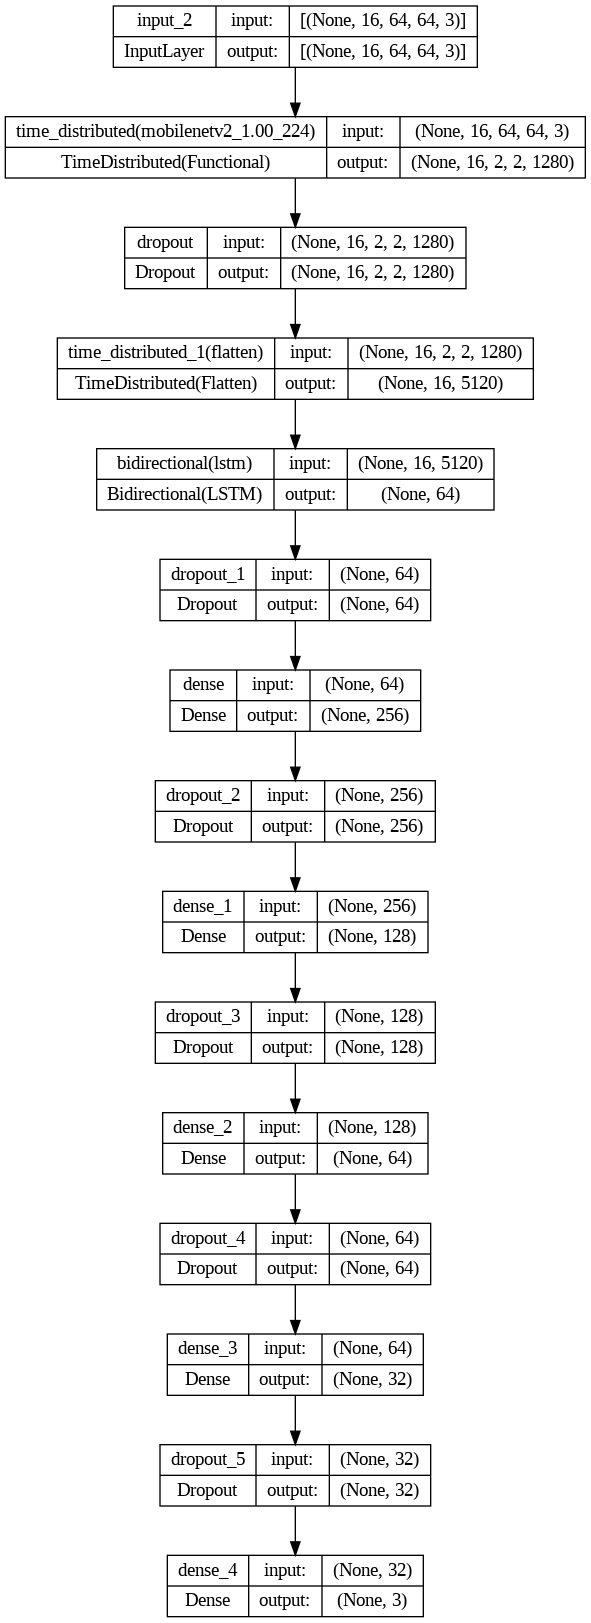

In [ ]:

MoBiLSTM_model = create_model()

plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Training of the model

In [ ]:
import tensorflow as tf
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)


MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
#  , callbacks = [early_stopping_callback,reduce_lr]

MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2)

Epoch 1/50
7/7 [==============================] - 23s 2s/step - loss: 1.1183 - accuracy: 0.3800 - val_loss: 1.0951 - val_accuracy: 0.3077
Epoch 2/50
7/7 [==============================] - 7s 1s/step - loss: 1.0924 - accuracy: 0.4000 - val_loss: 1.0878 - val_accuracy: 0.3077
Epoch 3/50
7/7 [==============================] - 17s 3s/step - loss: 1.0690 - accuracy: 0.4400 - val_loss: 1.0682 - val_accuracy: 0.4615
Epoch 4/50
7/7 [==============================] - 9s 1s/step - loss: 1.0959 - accuracy: 0.4200 - val_loss: 1.0611 - val_accuracy: 0.4615
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 1.0687 - accuracy: 0.4600 - val_loss: 1.0571 - val_accuracy: 0.4615
Epoch 6/50
7/7 [==============================] - 9s 1s/step - loss: 1.0622 - accuracy: 0.4600 - val_loss: 1.0514 - val_accuracy: 0.4615
Epoch 7/50
7/7 [==============================] - 10s 1s/step - loss: 1.0650 - accuracy: 0.4400 - val_loss: 1.0524 - val_accuracy: 0.4615
Epoch 8/50
7/7 [======================

Evaluation

In [ ]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

1/1 [==============================] - 0s 316ms/step - loss: 0.5931 - accuracy: 0.8571


Model save

In [ ]:
MoBiLSTM_model.save("/content/drive/MyDrive/MajorProjectExtras/ModelAugmented.h5")

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Use the trained model to predict the classes for the training set
Y_pred_train = MoBiLSTM_model.predict(features_train)

# Convert the one-hot-encoded vectors back to class labels
Y_train_labels = np.argmax(labels_train, axis=1)
Y_pred_train_labels = np.argmax(Y_pred_train, axis=1)

# Calculate the accuracy of the model on the training set
accuracy_train = accuracy_score(Y_train_labels, Y_pred_train_labels)

# Calculate the precision, recall, sensitivity, specificity, and AUC of the model on the training set
precision_train = precision_score(Y_train_labels, Y_pred_train_labels, average='weighted')
recall_train = recall_score(Y_train_labels, Y_pred_train_labels, average='weighted')

# Sensitivity (Recall for positive class)
sensitivity_train = recall_score(Y_train_labels, Y_pred_train_labels, average='macro')

# Specificity calculation
conf_matrix = confusion_matrix(Y_train_labels, Y_pred_train_labels)
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
specificity_train = tn / (tn + fp)

# ROC and AUC calculation (assuming binary classification for simplicity)
fpr_train, tpr_train, _ = roc_curve(labels_train.ravel(), Y_pred_train.ravel())
auc_score_train = auc(fpr_train, tpr_train)

# Generate a classification report for the training set
print("Classification Report (training set):\n")
print(classification_report(Y_train_labels, Y_pred_train_labels, target_names=CLASSES_LIST))

# Print the accuracy, precision, recall, sensitivity, specificity, and AUC values for the training set
print("Accuracy (training set): {:.2f}".format(accuracy_train))
print("Precision (training set): {:.2f}".format(precision_train))
print("Recall (training set): {:.2f}".format(recall_train))
print("Sensitivity (training set): {:.2f}".format(sensitivity_train))
print("Specificity (training set): {:.2f}".format(specificity_train))
print("AUC (training set): {:.2f}".format(auc_score_train))



2/2 [==============================] - 7s 3s/step
Classification Report (training set):

              precision    recall  f1-score   support

StreetFights       1.00      1.00      1.00        16
RoadAccident       1.00      0.86      0.92        28
   Explosion       0.83      1.00      0.90        19

    accuracy                           0.94        63
   macro avg       0.94      0.95      0.94        63
weighted avg       0.95      0.94      0.94        63

Accuracy (training set): 0.94
Precision (training set): 0.95
Recall (training set): 0.94
Sensitivity (training set): 0.95
Specificity (training set): 1.00
AUC (training set): 0.96


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, classification_report, confusion_matrix

# Use the trained model to predict the classes for the test set
Y_pred_test = MoBiLSTM_model.predict(features_test)

# Convert the one-hot-encoded vectors back to class labels
Y_test_labels = np.argmax(labels_test, axis=1)
Y_pred_test_labels = np.argmax(Y_pred_test, axis=1)

# Calculate the accuracy of the model on the test set
accuracy_test = accuracy_score(Y_test_labels, Y_pred_test_labels)

# Calculate the precision, recall, sensitivity, specificity, and AUC of the model on the test set
precision_test = precision_score(Y_test_labels, Y_pred_test_labels, average='weighted')
recall_test = recall_score(Y_test_labels, Y_pred_test_labels, average='weighted')

# Sensitivity (Recall for positive class)
sensitivity_test = recall_score(Y_test_labels, Y_pred_test_labels, average='macro')

# Specificity calculation
conf_matrix = confusion_matrix(Y_test_labels, Y_pred_test_labels)
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
specificity_test = tn / (tn + fp)

# ROC and AUC calculation (assuming binary classification for simplicity)
fpr_test, tpr_test, _ = roc_curve(labels_test.ravel(), Y_pred_test.ravel())
auc_score_test = auc(fpr_test, tpr_test)

# Generate a classification report for the test set
print("Classification Report (test set):\n")
print(classification_report(Y_test_labels, Y_pred_test_labels, target_names=CLASSES_LIST))

# Print the accuracy, precision, recall, sensitivity, specificity, and AUC values for the test set
print("Accuracy (test set): {:.2f}".format(accuracy_test))
print("Precision (test set): {:.2f}".format(precision_test))
print("Recall (test set): {:.2f}".format(recall_test))
print("Sensitivity (test set): {:.2f}".format(sensitivity_test))
print("Specificity (test set): {:.2f}".format(specificity_test))
print("AUC (test set): {:.2f}".format(auc_score_test))


1/1 [==============================] - 1s 680ms/step
Classification Report (test set):

              precision    recall  f1-score   support

StreetFights       0.80      1.00      0.89         4
RoadAccident       1.00      0.50      0.67         2
   Explosion       1.00      1.00      1.00         1

    accuracy                           0.86         7
   macro avg       0.93      0.83      0.85         7
weighted avg       0.89      0.86      0.84         7

Accuracy (test set): 0.86
Precision (test set): 0.89
Recall (test set): 0.86
Sensitivity (test set): 0.83
Specificity (test set): 1.00
AUC (test set): 0.94
